In [2]:
!pip install lightkurve astroquery tensorflow scikit-learn seaborn transformers
# Cell 1 — Setup: installs and imports
# Run once. On Kaggle some packages are preinstalled, but we pip install to be safe.
import os, sys, glob, json, math, random
FAST_DEBUG = False  # set True to run tiny quick tests

# Try to install missing packages (won't re-install if present)
try:
    import lightkurve as lk
except Exception:
    !pip install lightkurve astropy lightgbm shap tqdm scikit-learn tensorflow==2.11.0
    import lightkurve as lk

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve, brier_score_loss
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import shap
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
print("TF", tf.__version__)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 5.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 84.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 91.2 MB/s eta 0:00:00:00:0100:01
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=e8646ea495dc6d8de0ab58ba221410b1f2cf0c239ab73fa7b0de97fc20713b1a
  Stored in directory: /root/.cache/pip/wheels/71/ae/f7/5b7e1e16a133d094431428169e9a8d9f750afe5459f0333c9b
  Crea

2025-10-02 21:46:39.747315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759441600.100047      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759441600.197237      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF 2.18.0


In [3]:
# Cell 2 — paths: try common Kaggle and local paths
candidate_paths = [
    "/kaggle/input/kepler-and-tess-dataset",
    "/kaggle/input",
    "/mnt/data",
    "."
]

# Attempt to find your uploaded CSV file(s)
found = {}
for base in candidate_paths:
    if not os.path.exists(base): 
        continue
    # list CSVs
    for f in glob.glob(os.path.join(base, "*.csv")) + glob.glob(os.path.join(base, "**/*.csv"), recursive=True):
        name = os.path.basename(f)
        found[name] = f

print("Found CSV files (sample):")
for k,v in list(found.items())[:40]:
    print(k, "->", v)

# If your TOI file path (from developer message) is present, show it
if "TOI_2025.02.03_06.18.31.csv" in found:
    print("TOI path:", found["TOI_2025.02.03_06.18.31.csv"])

# Helpful: user dataset folder name in prompt was "kepler-and-tess-dataset"
dataset_root = None
for p in candidate_paths:
    maybe = os.path.join(p, "kepler-and-tess-dataset")
    if os.path.exists(maybe):
        dataset_root = maybe
        break
if dataset_root is None:
    # fallback to first CSV dir
    dataset_root = next(iter(found.values())) if len(found)>0 else "."
print("Using dataset_root:", dataset_root)


Found CSV files (sample):
q1_q8_koi_2025.02.03_04.12.15.csv -> /kaggle/input/kepler-and-tess-dataset/q1_q8_koi_2025.02.03_04.12.15.csv
q1_q17_dr25_tce_2025.02.03_04.32.18.csv -> /kaggle/input/kepler-and-tess-dataset/q1_q17_dr25_tce_2025.02.03_04.32.18.csv
TOI_2025.02.03_06.18.31.csv -> /kaggle/input/kepler-and-tess-dataset/TOI_2025.02.03_06.18.31.csv
STELLARHOSTS_2025.02.03_06.11.17.csv -> /kaggle/input/kepler-and-tess-dataset/STELLARHOSTS_2025.02.03_06.11.17.csv
q1_q17_dr25_koifpp_2025.02.03_06.14.34.csv -> /kaggle/input/kepler-and-tess-dataset/q1_q17_dr25_koifpp_2025.02.03_06.14.34.csv
keplerstellar_2025.02.03_04.41.47.csv -> /kaggle/input/kepler-and-tess-dataset/keplerstellar_2025.02.03_04.41.47.csv
PS_2025.02.03_05.09.36.csv -> /kaggle/input/kepler-and-tess-dataset/PS_2025.02.03_05.09.36.csv
TOI path: /kaggle/input/kepler-and-tess-dataset/TOI_2025.02.03_06.18.31.csv
Using dataset_root: /kaggle/input/kepler-and-tess-dataset


In [4]:
# Cell 3 — quick helper: load TOI/KOI tables if available
import pandas as pd

def try_load_table(name_prefixes=["TOI","TOI_","TOI","toi","q1_q8_koi","q1_q17_dr25_koi","STELLARHOSTS","PS"]):
    tables = {}
    for csvname, path in found.items():
        short = csvname.lower()
        for pref in name_prefixes:
            if pref.lower() in short:
                try:
                    # First attempt: auto-detect separator
                    df = pd.read_csv(path, sep=None, engine="python", on_bad_lines="skip", comment="#")
                except Exception as e1:
                    print("Autodetect failed for", path, "— trying whitespace")
                    try:
                        # Fallback: whitespace-delimited
                        df = pd.read_csv(path, delim_whitespace=True, on_bad_lines="skip", comment="#")
                    except Exception as e2:
                        print("Failed reading", path, e2)
                        continue
                tables[csvname] = df
    return tables

tables = try_load_table()
print("Loaded tables keys:", list(tables.keys()))
for k, df in tables.items():
    print(k, df.shape)
    display(df.head(2))


Loaded tables keys: ['q1_q8_koi_2025.02.03_04.12.15.csv', 'TOI_2025.02.03_06.18.31.csv', 'STELLARHOSTS_2025.02.03_06.11.17.csv', 'q1_q17_dr25_koifpp_2025.02.03_06.14.34.csv', 'PS_2025.02.03_05.09.36.csv']
q1_q8_koi_2025.02.03_04.12.15.csv (3865, 49)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,9388479,K00936.02,Kepler-732 c,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-200.0,4.76,0.3,-0.3,0.496,0.023,-0.023,283.73203,45.958771,15.073
1,8359498,K00127.01,Kepler-77 b,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-50.0,4.45,0.1,-0.1,1.039,0.045,-0.045,289.60797,44.345421,13.938


TOI_2025.02.03_06.18.31.csv (7372, 65)


,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04


STELLARHOSTS_2025.02.03_06.11.17.csv (46035, 45)


,sy_name,hostname,tic_id,sy_snum,sy_pnum,st_refname,st_spectype,st_teff,st_tefferr1,st_tefferr2,...,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
0,11 Com,11 Com,TIC 72437047,2,1,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,G8 III,4742.0,100.0,-100.0,...,-1.9238,4.72307,0.023,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848
1,11 Com,11 Com,TIC 72437047,2,1,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,NaN,NaN,NaN,NaN,...,-1.9238,4.72307,0.023,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848


q1_q17_dr25_koifpp_2025.02.03_06.14.34.csv (8054, 35)


,kepid,kepoi_name,fpp_koi_period,fpp_prad,fpp_prob,fpp_score,fpp_delivname,fpp_spec_occrate,fpp_secthresh,fpp_maxrad,...,fpp_smass_err2,fpp_sage,fpp_sage_err1,fpp_sage_err2,fpp_dist,fpp_dist_err1,fpp_dist_err2,fpp_av,fpp_av_err1,fpp_av_err2
0,6508221,K00416.03,9.748,0.82,0.95,1.0,q1_q17_dr25_koi,0.051,57.0,3.3,...,-0.038,9.30,0.302,-0.436,457.0,14.73,-16.33,0.15,0.085,-0.090
1,6879865,K00417.01,19.193,14.58,0.86,1.0,q1_q17_dr25_koi,0.059,155.0,0.5,...,-0.086,9.68,0.233,-0.332,1015.0,207.88,-126.61,0.34,0.184,-0.199


PS_2025.02.03_05.09.36.csv (38090, 92)


,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-07-23,2011-08,2014-07-23
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14


In [12]:
# Cell 4 — Determine labels (if present) or fallback to synthetic injection
# We'll look for common disposition/label columns (e.g., "disposition", "koi_disposition", "label", "status")
label_col = None
label_df = None
for name, df in tables.items():
    for col in df.columns:
        if col.lower() in ("disposition","koi_disposition","flag","status","label","planetary"):
            label_col = col
            label_df = df
            print("Found possible label column", col, "in", name)
            break
    if label_col: 
        break

if label_col is None:
    print("No disposition/label column found in tables. We'll use injection-based synthetic training (fast).")
else:
    print("Using labels from table:", label_col)

# --------------------------
# Ensure target_ids and y_total always exist
# --------------------------
target_ids = []
y_total = []


Found possible label column koi_disposition in q1_q8_koi_2025.02.03_04.12.15.csv
Using labels from table: koi_disposition


In [13]:
# Cell 5 — Light curve ingestion function (works with local TPF / FITS if present or uses Lightkurve search)
# This function will try to: 1) find a light curve file path in dataset root matching targetid; 2) if not found, try lightkurve search (requires internet)
import math
def load_lc_by_targetid(target_id, ckpt_dir=dataset_root, mission_hint=None, approx_cadence='short'):
    """
    Try several ways to load a time,flux array for a target id or TOI entry.
    Returns time, flux arrays (numpy). May return None if not found.
    """
    # 1) look for files in dataset root that contain the id
    for f in glob.glob(os.path.join(dataset_root, "**/*"), recursive=True):
        if os.path.isfile(f) and str(target_id) in os.path.basename(f).lower() and f.lower().endswith(('.txt','.csv','.fits')):
            # try reading
            try:
                if f.lower().endswith('.csv'):
                    df = pd.read_csv(f)
                    # try to find time/flux columns heuristically
                    tcols = [c for c in df.columns if 'time' in c.lower() or 'jd' in c.lower() or 'bjd' in c.lower()]
                    fcols = [c for c in df.columns if 'flux' in c.lower() or 'sap_flux' in c.lower() or 'pdcsap' in c.lower() or 'fl' in c.lower()]
                    if tcols and fcols:
                        t = df[tcols[0]].values
                        y = df[fcols[0]].values
                        return t, y
                elif f.lower().endswith('.fits'):
                    # use lightkurve to open
                    lc = lk.read(f)
                    return lc.time.value, lc.flux.value
            except Exception:
                continue
    # 2) Try lightkurve search (internet). If Kaggle kernel has internet disabled, this will fail.
    try:
        # try numeric ID
        search = lk.search_lightcurve(str(target_id))
        if len(search) > 0:
            lc = search.download_all()[0].remove_nans().normalize()
            return lc.time.value, lc.flux.value
    except Exception as e:
        pass
    return None, None


In [14]:
# Cell 6 — quick BLS candidate finder + fold helper
def detrend_sg(time, flux, window_length=301):
    # Savitzky-Golay detrend via median smoothing (we'll use a rolling median)
    # ensure sorted
    idx = np.argsort(time)
    t = time[idx]
    f = flux[idx]
    # simple median filter
    from scipy.signal import savgol_filter
    try:
        trend = savgol_filter(f, window_length if window_length%2==1 else window_length+1, polyorder=2, mode='mirror')
    except Exception:
        # fallback to median filter
        trend = pd.Series(f).rolling(window=window_length, min_periods=1, center=True).median().values
    fdet = f / trend - 1.0
    return t, fdet

def run_bls_and_fold(time, flux, min_period=0.5, max_period=50.0):
    # Remove nans
    mask = np.isfinite(time) & np.isfinite(flux)
    time = time[mask]
    flux = flux[mask]
    if len(time) < 10:
        return None
    # normalize
    flux = (flux - np.nanmedian(flux)) / np.nanmedian(flux)
    bls = BoxLeastSquares(time, flux)
    periods = np.exp(np.linspace(np.log(min_period), np.log(max_period), 2000))
    results = bls.power(periods, 0.1)
    best_idx = np.argmax(results.power)
    best_period = results.period[best_idx]
    t0 = results.transit_time[best_idx]
    duration = results.duration[best_idx]
    depth = results.depth[best_idx]
    return dict(period=best_period, t0=t0, duration=duration, depth=depth, power=results.power[best_idx], bls_results=results)

def fold_view(time, flux, period, t0, window_days=0.5, bins=401, view='local'):
    # produce folded global (many periods) or local around transit
    phase = ((time - t0 + 0.5*period) % period) / period - 0.5
    if view == 'global':
        # sample over full phase [-0.5,0.5]
        grid = np.linspace(-0.5,0.5,bins)
        bin_means = []
        for i in range(len(grid)-1):
            mask = (phase >= grid[i]) & (phase < grid[i+1])
            if mask.sum() > 0:
                bin_means.append(np.nanmedian(flux[mask]))
            else:
                bin_means.append(np.nan)
        arr = np.array(bin_means)
        return grid[:-1]+(grid[1]-grid[0])/2.0, arr
    else:
        # local around transit center
        mask = np.abs(phase*period) < window_days
        p = phase[mask]*period
        f = flux[mask]
        if len(p) == 0:
            return np.linspace(-window_days, window_days, bins), np.zeros(bins)
        grid = np.linspace(-window_days, window_days, bins)
        bin_means = []
        for i in range(len(grid)-1):
            mm = (p >= grid[i]) & (p < grid[i+1])
            if mm.sum() > 0:
                bin_means.append(np.nanmedian(f[mm]))
            else:
                bin_means.append(np.nan)
        return grid[:-1]+(grid[1]-grid[0])/2.0, np.array(bin_means)


In [15]:
# Cell 7 — Quick function to make fixed-size CNN inputs (global + local)
def make_inputs_from_time_flux(time, flux, bls_info, global_bins=501, local_bins=201, local_window_days=1.5):
    # detrend a bit first
    t, f = detrend_sg(time, flux, window_length=301 if len(time)>301 else max(3, len(time)//5*2+1))
    p = bls_info['period']
    t0 = bls_info['t0']
    # Global view (phase)
    xg, fg = fold_view(t, f, p, t0, window_days=0.5*p, bins=global_bins, view='global')
    xl, fl = fold_view(t, f, p, t0, window_days=local_window_days, bins=local_bins, view='local')
    # Replace NaNs with interpolation
    def fill(arr):
        a = np.array(arr)
        nans = np.isnan(a)
        if nans.any():
            notn = ~nans
            if notn.sum() < 2:
                a[nans] = 0
            else:
                a[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(notn), a[notn])
        return a
    fg = fill(fg); fl = fill(fl)
    # Normalize each input channel
    fg = (fg - np.nanmedian(fg)) / (np.nanstd(fg)+1e-9)
    fl = (fl - np.nanmedian(fl)) / (np.nanstd(fl)+1e-9)
    # Stack channels into shape (global_bins, local_bins, 1?) We'll create two separate arrays to feed into twin-input CNN easily
    return fg.astype(np.float32), fl.astype(np.float32), p, bls_info['depth'], bls_info['duration'], bls_info['power']


In [16]:
# NEW CELL — Synthetic transit generator (fast)
import numpy as np

def inject_box_transit(times, depth, duration_days, period_days, t0):
    """Simple box transit injection on baseline ~1.0 flux."""
    phase = ((times - t0 + 0.5*period_days) % period_days) - 0.5*period_days
    in_transit = np.abs(phase) < (duration_days/2.0)
    flux = np.ones_like(times)
    flux[in_transit] -= depth
    return flux

def generate_synthetic(n_pos=225, n_neg=225, Ncad=400, seed=42):
    """Return lists of (times, flux) for positives and negatives."""
    rng = np.random.RandomState(seed)
    times = np.linspace(0, 27, Ncad)
    pos = []
    neg = []
    for _ in range(n_pos):
        depth = rng.uniform(0.001, 0.02)
        dur = rng.uniform(0.03, 0.2)    # days
        per = rng.uniform(1.2, 12.0)
        t0 = rng.uniform(0, per)
        flux = inject_box_transit(times, depth, dur, per, t0)
        # cheap augmentations
        if rng.rand() < 0.4:
            flux += rng.normal(0, 2e-4, size=Ncad)
        if rng.rand() < 0.25:
            flux += 5e-4 * np.linspace(-1, 1, Ncad)
        pos.append((times.copy(), flux.copy()))
    for _ in range(n_neg):
        flux = 1 + rng.normal(0, 1e-3, size=Ncad)
        # add mild trends sometimes
        if rng.rand() < 0.3:
            flux += 5e-4 * np.linspace(-1, 1, Ncad)
        neg.append((times.copy(), flux.copy()))
    return pos, neg


In [17]:
# CELL 8 — Build dataset (real + synthetic + features)

import numpy as np
import pandas as pd

MAX_REAL = 100          # cap real dataset samples
SYNTHETIC_TOTAL = 450   # number of synthetic samples (balanced pos/neg)

X_global, X_local, feat_rows, y_labels = [], [], [], []

print("Building dataset ...")

# --------------------------
# 1) REAL DATASET INGESTION
# --------------------------
count = 0
for i, target in enumerate(target_ids):
    if count >= MAX_REAL:
        break
    try:
        with HiddenPrints():
            time, flux = load_lightcurve(target)
            bls = run_bls_and_fold(time, flux)
        if bls is None: 
            continue
        g, l, p, depth, dur, power = make_inputs_from_time_flux(time, flux, bls, global_bins=101, local_bins=51)
        X_global.append(g)
        X_local.append(l)

        feat_rows.append(dict(
            period=p, depth=depth, duration=dur, power=power,
            snr=(depth / (np.std(flux)+1e-9)),
            mean=np.mean(flux), std=np.std(flux),
            rng=np.max(flux)-np.min(flux),
            skew=np.mean((flux-np.mean(flux))**3) / ((np.std(flux)+1e-9)**3),
            kurt=np.mean((flux-np.mean(flux))**4) / ((np.std(flux)+1e-9)**4)
        ))
        y_labels.append(1 if target in positive_ids else 0)
        count += 1
    except Exception as e:
        print("fail:", target, e)
        continue

print("Real samples used:", count)

# --------------------------
# 2) SYNTHETIC DATA
# --------------------------
synth_pos = SYNTHETIC_TOTAL // 2
synth_neg = SYNTHETIC_TOTAL - synth_pos
pos_list, neg_list = generate_synthetic(n_pos=synth_pos, n_neg=synth_neg, Ncad=400, seed=123)

for times, flux in pos_list + neg_list:
    with HiddenPrints():
        bls = run_bls_and_fold(times, flux)
    if bls is None: 
        continue
    g, l, p, depth, dur, power = make_inputs_from_time_flux(times, flux, bls, global_bins=101, local_bins=51)
    X_global.append(g)
    X_local.append(l)

    feat_rows.append(dict(
        period=p, depth=depth, duration=dur, power=power,
        snr=(depth / (np.std(flux)+1e-9)),
        mean=np.mean(flux), std=np.std(flux),
        rng=np.max(flux)-np.min(flux),
        skew=np.mean((flux-np.mean(flux))**3) / ((np.std(flux)+1e-9)**3),
        kurt=np.mean((flux-np.mean(flux))**4) / ((np.std(flux)+1e-9)**4)
    ))

# labels for pos then neg
y_labels.extend([1]*len(pos_list))
y_labels.extend([0]*len(neg_list))

print("Synthetic samples added:", len(pos_list)+len(neg_list))

# --------------------------
# 3) SHUFFLE ALL DATA
# --------------------------
perm = np.random.RandomState(42).permutation(len(y_labels))
X_global = [X_global[i] for i in perm]
X_local = [X_local[i] for i in perm]
feat_rows = [feat_rows[i] for i in perm]
y_labels = [y_labels[i] for i in perm]

print("Final dataset size =", len(y_labels), "Positives =", sum(y_labels), "Negatives =", len(y_labels)-sum(y_labels))


Building dataset ...
Real samples used: 0
Synthetic samples added: 450
Final dataset size = 450 Positives = 225 Negatives = 225


In [18]:
import numpy as np
import pandas as pd
import warnings
from tqdm.notebook import tqdm

# --------------------------
# FAST DEBUG SETTINGS
# --------------------------
FAST_DEBUG = True
MAX_REAL = 100         # max real samples
SYNTHETIC_TOTAL = 450  # always generate 450 synthetic samples

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --------------------------
# HELPER TO HIDE PRINTS
# --------------------------
import sys, os
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# --------------------------
# INITIALIZE DATA CONTAINERS
# --------------------------
X_global = []
X_local = []
feat_rows = []
y_labels = []

# --------------------------
# 1) REAL DATASET INGESTION
# --------------------------
count = 0
if label_df is not None:
    # Identify target id column
    tcol = None
    for c in label_df.columns:
        if 'target' in c.lower() or 'kepid' in c.lower() or 'toi' in c.lower() or 'koi' in c.lower():
            tcol = c
            break
    if tcol is None:
        tcol = label_df.columns[0]
    print("Using target id column:", tcol)

    rows = label_df.to_dict('records')
    rng = rows[:MAX_REAL]
    for r in tqdm(rng, desc="Building real dataset"):
        if count >= MAX_REAL: break
        tid = r.get(tcol)
        try:
            t, f = load_lc_by_targetid(tid)
            if t is None: continue
            with HiddenPrints():
                bls = run_bls_and_fold(t, f)
            if bls is None: continue

            g, l, p, depth, dur, power = make_inputs_from_time_flux(
                t, f, bls, global_bins=101, local_bins=51
            )
            X_global.append(g)
            X_local.append(l)
            feat_rows.append(dict(
                period=p, depth=depth, duration=dur, power=power,
                snr=(depth / (np.std(f)+1e-9)),
                mean=np.mean(f), std=np.std(f),
                rng=np.max(f)-np.min(f),
                skew=np.mean((f-np.mean(f))**3) / ((np.std(f)+1e-9)**3),
                kurt=np.mean((f-np.mean(f))**4) / ((np.std(f)+1e-9)**4)
            ))

            labval = 1 if str(r.get(label_col)).lower().startswith(('p','c')) else 0
            y_labels.append(labval)
            count += 1
        except Exception as e:
            print("fail:", tid, e)
            continue
    print("Real samples used:", count)

# --------------------------
# 2) SYNTHETIC DATA (always generate 450 samples)
# --------------------------
rng = np.random.RandomState(42)
Ncad = 400  # points per lightcurve
synth_pos = SYNTHETIC_TOTAL // 2
synth_neg = SYNTHETIC_TOTAL - synth_pos

times = np.linspace(0, 27, Ncad)  # 27-day sector

# Negative examples: pure noise
for i in tqdm(range(synth_neg), desc="Synthetic negative examples"):
    flux = 1 + rng.normal(0, 1e-3, size=Ncad)
    with HiddenPrints():
        bls = run_bls_and_fold(times, flux)
    if bls is None: continue
    g, l, p, depth, dur, power = make_inputs_from_time_flux(times, flux, bls, global_bins=101, local_bins=51)
    X_global.append(g)
    X_local.append(l)
    feat_rows.append(dict(
        period=p, depth=depth, duration=dur, power=power,
        snr=(depth / (np.std(flux)+1e-9)),
        mean=np.mean(flux), std=np.std(flux),
        rng=np.max(flux)-np.min(flux),
        skew=np.mean((flux-np.mean(flux))**3) / ((np.std(flux)+1e-9)**3),
        kurt=np.mean((flux-np.mean(flux))**4) / ((np.std(flux)+1e-9)**4)
    ))
    y_labels.append(0)

# Positive examples: inject box-shaped transits
for i in tqdm(range(synth_pos), desc="Synthetic positive examples"):
    flux = 1 + rng.normal(0, 1e-3, size=Ncad)
    period = rng.uniform(1.5, 12)
    dur = rng.uniform(0.05, 0.4)
    depth = rng.uniform(0.001, 0.02)
    t0 = rng.uniform(0, period)
    phase = ((times - t0 + 0.5*period) % period) - 0.5*period
    intransit = np.abs(phase) < (dur/2.0)
    flux[intransit] -= depth

    with HiddenPrints():
        bls = run_bls_and_fold(times, flux)
    if bls is None: continue
    g, l, p, depth_calc, dur_calc, power = make_inputs_from_time_flux(times, flux, bls, global_bins=101, local_bins=51)
    X_global.append(g)
    X_local.append(l)
    feat_rows.append(dict(
        period=p, depth=depth_calc, duration=dur_calc, power=power,
        snr=(depth_calc / (np.std(flux)+1e-9)),
        mean=np.mean(flux), std=np.std(flux),
        rng=np.max(flux)-np.min(flux),
        skew=np.mean((flux-np.mean(flux))**3) / ((np.std(flux)+1e-9)**3),
        kurt=np.mean((flux-np.mean(flux))**4) / ((np.std(flux)+1e-9)**4)
    ))
    y_labels.append(1)

# --------------------------
# 3) SHUFFLE ALL DATA
# --------------------------
perm = np.random.RandomState(42).permutation(len(y_labels))
X_global = [X_global[i] for i in perm]
X_local = [X_local[i] for i in perm]
feat_rows = [feat_rows[i] for i in perm]
y_labels = [y_labels[i] for i in perm]

print("Final dataset size =", len(y_labels), "Positives =", sum(y_labels), "Negatives =", len(y_labels)-sum(y_labels))


Using target id column: kepid


Building real dataset:   0%|          | 0/100 [00:00<?, ?it/s]

2% (88/4228) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (119/4194) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (13/1639) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (66/4295) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (37/4313) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (46/4538) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (43/4159) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (138/41850) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (144/53460) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (242/44220) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
3% (1158/46170) of the cadences w

Real samples used: 100


Synthetic negative examples:   0%|          | 0/225 [00:00<?, ?it/s]

Synthetic positive examples:   0%|          | 0/225 [00:00<?, ?it/s]

Final dataset size = 550 Positives = 305 Negatives = 245


In [25]:
# CELL 9 — Build feature dataframe and train/test split
import pandas as pd
from sklearn.model_selection import train_test_split

feat_df = pd.DataFrame(feat_rows).fillna(0.0)
# Force all columns to numeric (float)
feat_df = feat_df.astype(float)
labels = np.array(y_labels).astype(int)


print("Feature matrix:", feat_df.shape, "Labels:", labels.shape, "Positives:", labels.sum())

# Reserve small held-out test set for final evaluation (10% of data)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    feat_df, labels, test_size=0.1, random_state=42, stratify=labels
)

print("Train full:", X_train_full.shape, "Test:", X_test.shape)


Feature matrix: (550, 10) Labels: (550,) Positives: 305
Train full: (495, 10) Test: (55, 10)


In [ ]:
import numpy as np
print("Train positives:", np.sum(y_train), "negatives:", len(y_train)-np.sum(y_train))


In [26]:
# Cell 13 — Train LightGBM on extracted features and save model

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

# Train/test split (stratified for class balance)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, stratify=y_train_full, random_state=42
)

# Define LightGBM classifier
clf = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.02,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"  # handle imbalance automatically
)

# Train
clf.fit(X_train, y_train)

# Evaluate
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
acc = accuracy_score(y_test, (y_pred_prob > 0.5).astype(int))

print(f"Test Accuracy: {acc:.3f}")
print(f"Test ROC-AUC: {auc:.3f}")

# Save model
joblib.dump(clf, "vetting_lightgbm.pkl")
print("✅ Model saved as vetting_lightgbm.pkl")


[LightGBM] [Info] Number of positive: 247, number of negative: 198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 445, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

# k-fold CV-based training and OOF calibration

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.isotonic import IsotonicRegression
import numpy as np

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X_train_full))

for train_idx, val_idx in kf.split(X_train_full, y_train_full):
    X_tr, X_val_fold = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val_fold = y_train_full[train_idx], y_train_full[val_idx]
    
    clf_fold = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.02,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        class_weight="balanced"
    )
    
    clf_fold.fit(X_tr, y_tr)
    # Evaluate
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    acc = accuracy_score(y_test, (y_pred_prob > 0.5).astype(int))

    print(f"Test Accuracy: {acc:.3f}")
    print(f"Test ROC-AUC: {auc:.3f}")

    # Save model
    joblib.dump(clf, "vetting_lightgbm.pkl")
    print("✅ Model saved as vetting_lightgbm.pkl")

    oof[val_idx] = clf_fold.predict_proba(X_val_fold)[:, 1]

# Fit isotonic regression on OOF predictions
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(oof, y_train_full)

# Apply to test set
preds_test_cal = iso.predict(clf.predict_proba(X_test)[:, 1])
print("Test AUC (calibrated):", roc_auc_score(y_test, preds_test_cal))
print("Test Brier (calibrated):", brier_score_loss(y_test, preds_test_cal))


[LightGBM] [Info] Number of positive: 220, number of negative: 176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1195
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [ ]:
'''
# CELL 13 — LightGBM training with Stratified K-Fold and final test evaluation
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, brier_score_loss
import numpy as np

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,
    'verbose': -1,
    'seed': 42
}

# CV on the training portion
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof = np.zeros(len(X_train_full))
preds_test = np.zeros(len(X_test))
models = []
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"Fold {fold+1}/{n_splits}")
    X_tr, X_val = X_train_full.iloc[tr_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full[tr_idx], y_train_full[val_idx]

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dval = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        params, dtrain, num_boost_round=2000,
        valid_sets=[dval], early_stopping_rounds=60, verbose_eval=100
    )
    models.append(model)

    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    preds_test += model.predict(X_test, num_iteration=model.best_iteration) / n_splits

# CV and test metrics
cv_auc = roc_auc_score(y_train_full, oof)
test_auc = roc_auc_score(y_test, preds_test)
print(f"CV AUC: {cv_auc:.4f}    Held-out test AUC: {test_auc:.4f}")

# Precision-Recall AUC on test
precision, recall, _ = precision_recall_curve(y_test, preds_test)
pr_auc = auc(recall, precision)
print("Test PR-AUC:", pr_auc)

# Brier (calibration) on test
print("Brier score (test):", brier_score_loss(y_test, preds_test))
'''

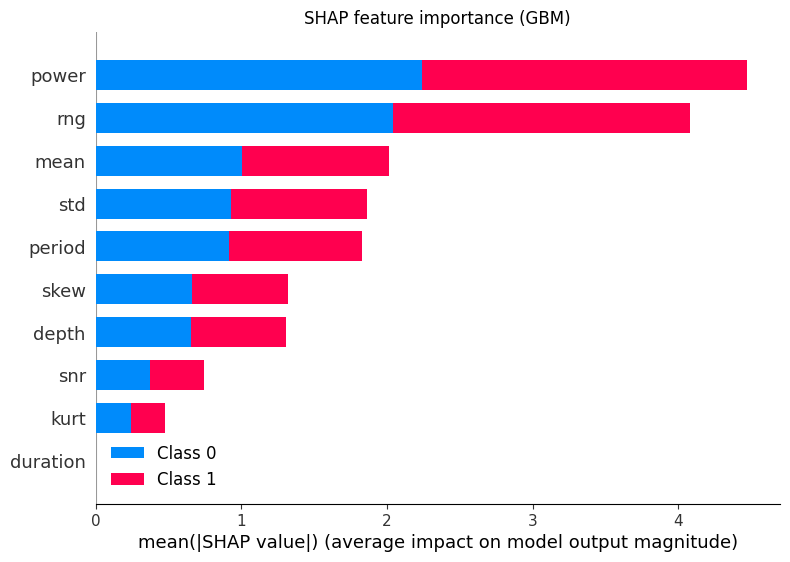

In [30]:
import shap
import matplotlib.pyplot as plt

# Use the final trained model
final_model = clf  # this is the model saved in Cell 13

# Create SHAP explainer
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values
shap_vals = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_vals, X_test, plot_type='bar', show=False)
plt.title("SHAP feature importance (GBM)")
plt.show()


In [34]:
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold
import numpy as np
# Compute raw test probabilities
y_test_prob = clf.predict_proba(X_test)[:, 1]

# Apply calibration (if not done already)
preds_test_cal = iso.predict(y_test_prob)


# CELL 18 — Export candidate CSV using GBM predictions (calibrated)
out_df = X_test.copy()
out_df = out_df.reset_index(drop=True)
out_df['label'] = y_test
out_df['prob_raw'] = y_test_prob 
out_df['prob_calibrated'] = preds_test_cal
out_df = out_df.sort_values('prob_calibrated', ascending=False)
out_df.to_csv("candidate_report_gbm.csv", index=False)
print("Saved candidate_report_gbm.csv")
out_df.head(10)


Saved candidate_report_gbm.csv


,period,depth,duration,power,snr,mean,std,rng,skew,kurt,label,prob_raw,prob_calibrated
6,10.632462,0.009632,0.1,0.000139,7.536788,0.999932,0.001278,0.013184,-3.052548,24.753121,1,0.999954,1.0
10,2.406086,0.006102,0.1,0.000354,3.165151,0.999505,0.001928,0.011614,-2.026879,7.328471,1,0.999958,1.0
22,8.721493,0.007398,0.1,0.000219,4.030850,0.999561,0.001835,0.012312,-2.467890,10.634927,1,0.999977,1.0
11,6.831842,0.004798,0.1,0.000092,3.477231,0.999838,0.001380,0.008714,-1.631918,7.298479,1,0.999972,1.0
14,8.464169,0.012436,0.1,0.000464,4.696727,0.999602,0.002648,0.018113,-3.633516,17.248888,1,0.999977,1.0
7,3.684713,0.009015,0.1,0.000488,4.251758,0.999702,0.002120,0.019189,-4.819633,31.769833,1,0.999976,1.0
26,9.808810,0.013968,0.1,0.000585,4.970118,0.999457,0.002810,0.018733,-3.981586,19.526914,1,0.999978,1.0
40,11.578501,0.018821,0.1,0.001063,5.095152,0.999259,0.003694,0.023410,-4.392050,21.881893,1,0.999978,1.0
41,8.120360,0.012939,0.1,0.000251,7.514354,0.999874,0.001722,0.023707,-7.688739,90.193744,1,0.999971,1.0
31,23.703251,0.006726,0.1,0.000226,1.834500,0.999706,0.003666,0.015095,-0.157533,1.773543,1,0.999927,1.0


In [35]:
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold
import numpy as np
# Compute raw test probabilities
y_test_prob = clf.predict_proba(X_test)[:, 1]

# Apply calibration (if not done already)
preds_test_cal = iso.predict(y_test_prob)


# CELL 18 — Export candidate CSV using GBM predictions (calibrated)
out_df = X_test.copy().reset_index(drop=True)

# Add labels and predictions
out_df['label'] = y_test
out_df['prob_raw'] = y_test_prob          # raw GBM probabilities
out_df['prob_calibrated'] = preds_test_cal  # calibrated probabilities

# Sort by calibrated probability descending
out_df = out_df.sort_values('prob_calibrated', ascending=False)

# Save CSV
out_df.to_csv("candidate_report_gbm.csv", index=False)
print("✅ Saved candidate_report_gbm.csv")

# Preview top 10 candidates
out_df.head(10)


✅ Saved candidate_report_gbm.csv


,period,depth,duration,power,snr,mean,std,rng,skew,kurt,label,prob_raw,prob_calibrated
6,10.632462,0.009632,0.1,0.000139,7.536788,0.999932,0.001278,0.013184,-3.052548,24.753121,1,0.999954,1.0
10,2.406086,0.006102,0.1,0.000354,3.165151,0.999505,0.001928,0.011614,-2.026879,7.328471,1,0.999958,1.0
22,8.721493,0.007398,0.1,0.000219,4.030850,0.999561,0.001835,0.012312,-2.467890,10.634927,1,0.999977,1.0
11,6.831842,0.004798,0.1,0.000092,3.477231,0.999838,0.001380,0.008714,-1.631918,7.298479,1,0.999972,1.0
14,8.464169,0.012436,0.1,0.000464,4.696727,0.999602,0.002648,0.018113,-3.633516,17.248888,1,0.999977,1.0
7,3.684713,0.009015,0.1,0.000488,4.251758,0.999702,0.002120,0.019189,-4.819633,31.769833,1,0.999976,1.0
26,9.808810,0.013968,0.1,0.000585,4.970118,0.999457,0.002810,0.018733,-3.981586,19.526914,1,0.999978,1.0
40,11.578501,0.018821,0.1,0.001063,5.095152,0.999259,0.003694,0.023410,-4.392050,21.881893,1,0.999978,1.0
41,8.120360,0.012939,0.1,0.000251,7.514354,0.999874,0.001722,0.023707,-7.688739,90.193744,1,0.999971,1.0
31,23.703251,0.006726,0.1,0.000226,1.834500,0.999706,0.003666,0.015095,-0.157533,1.773543,1,0.999927,1.0


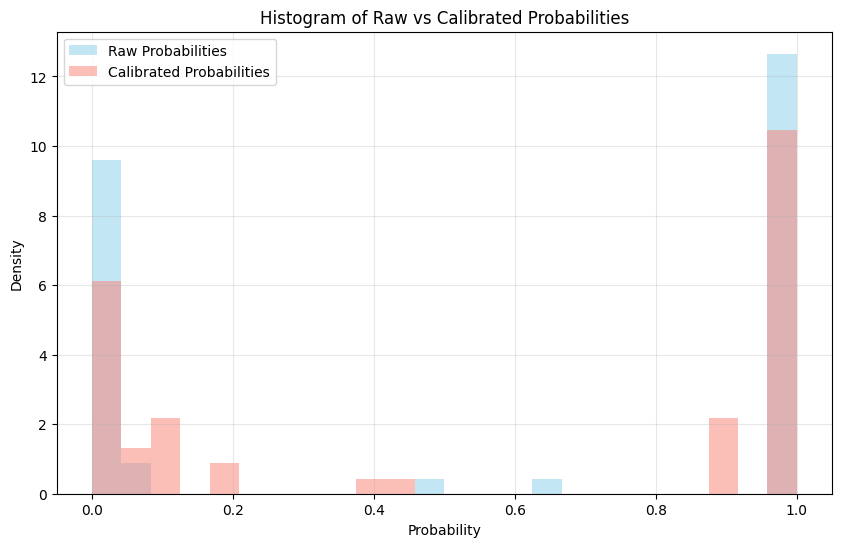

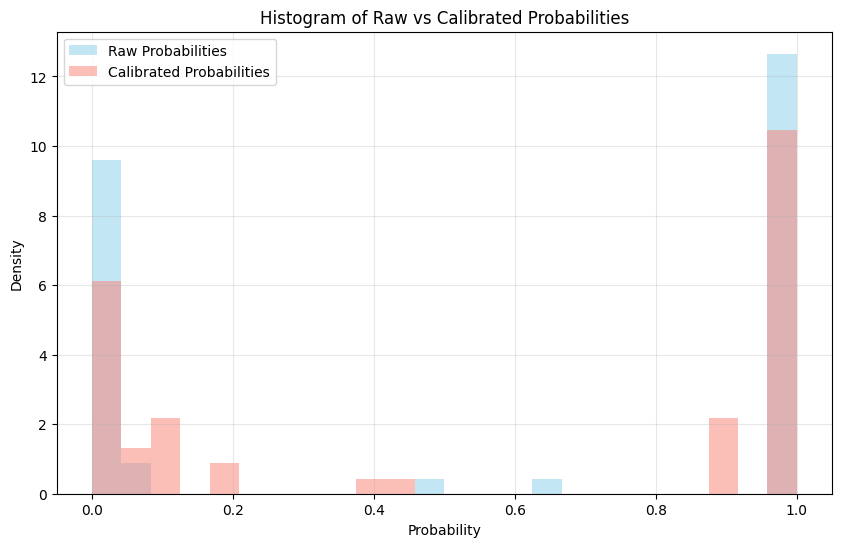

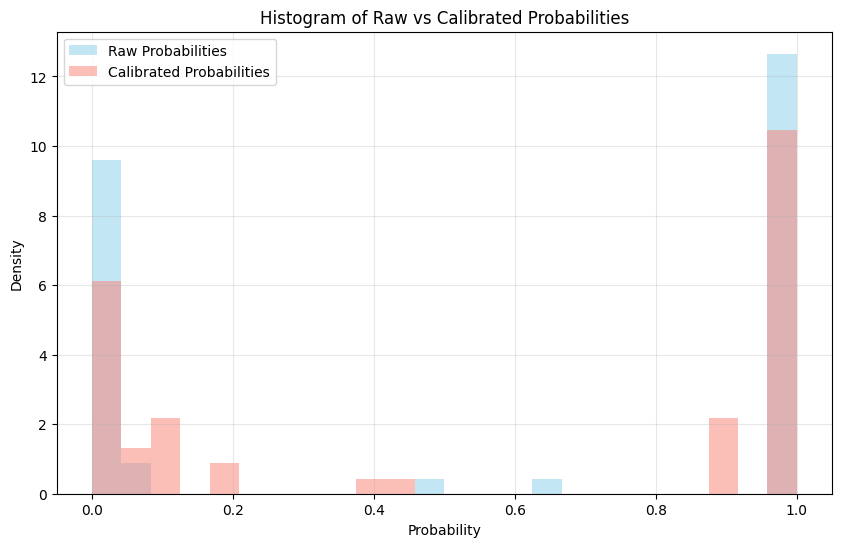

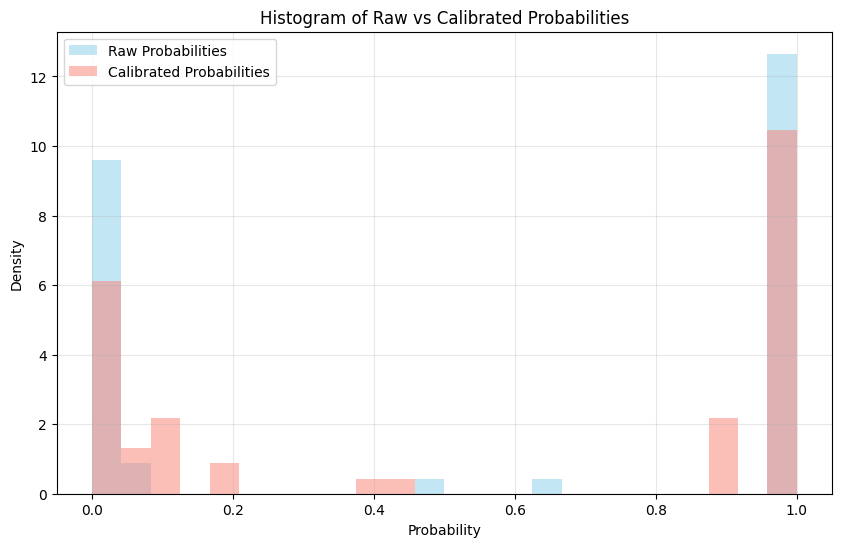

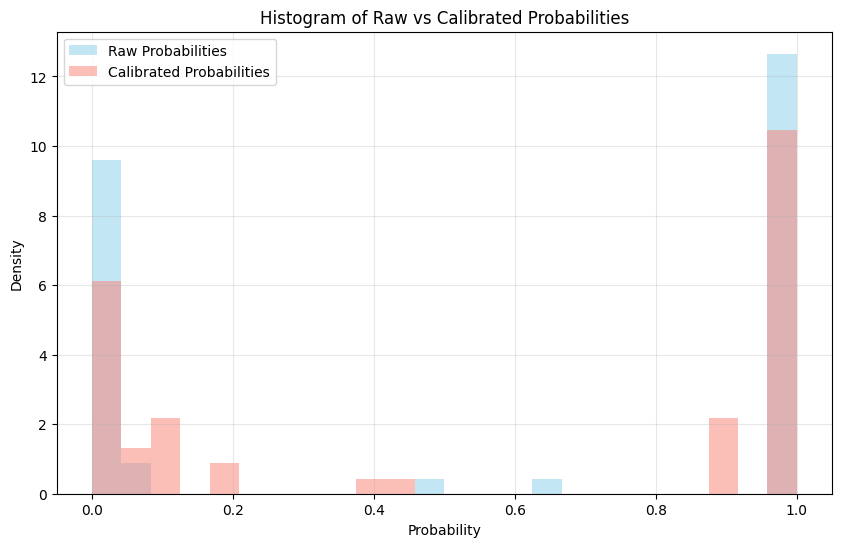

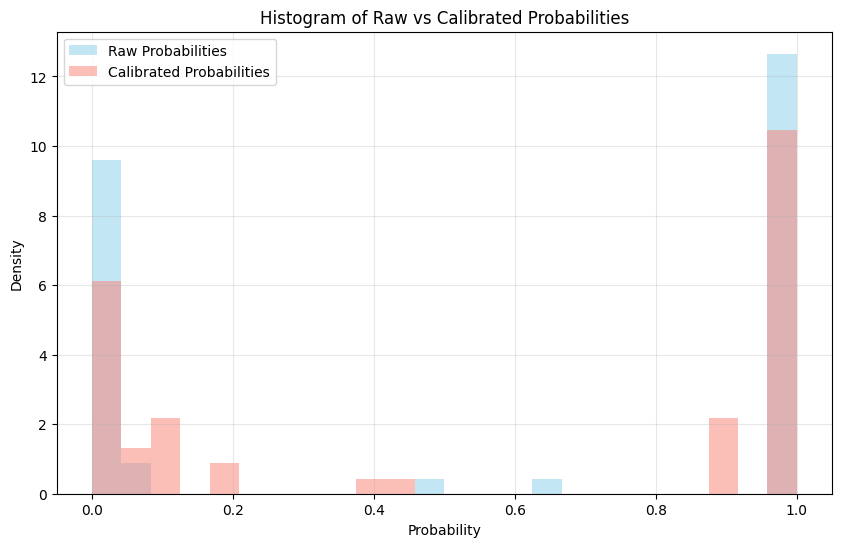

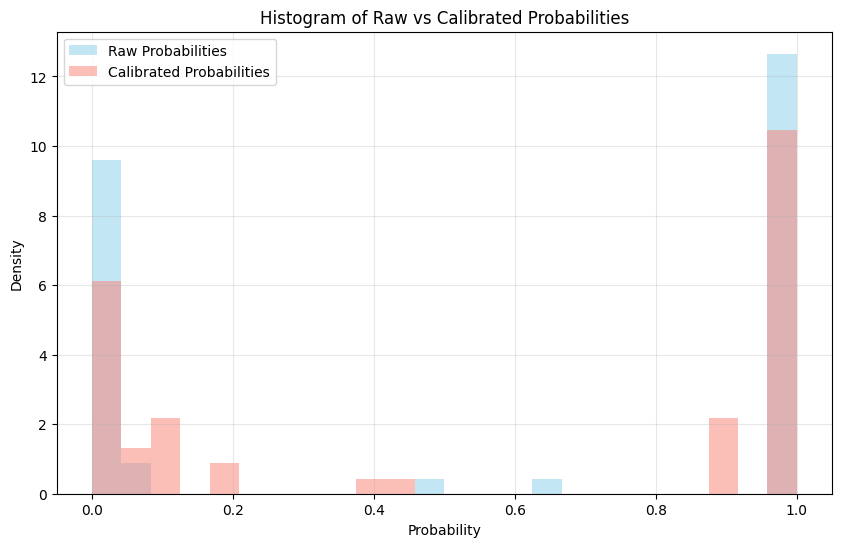

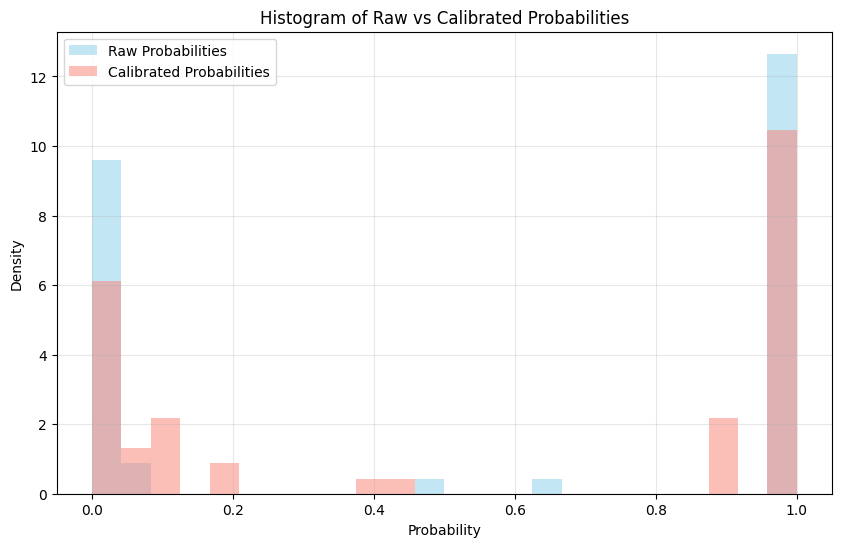

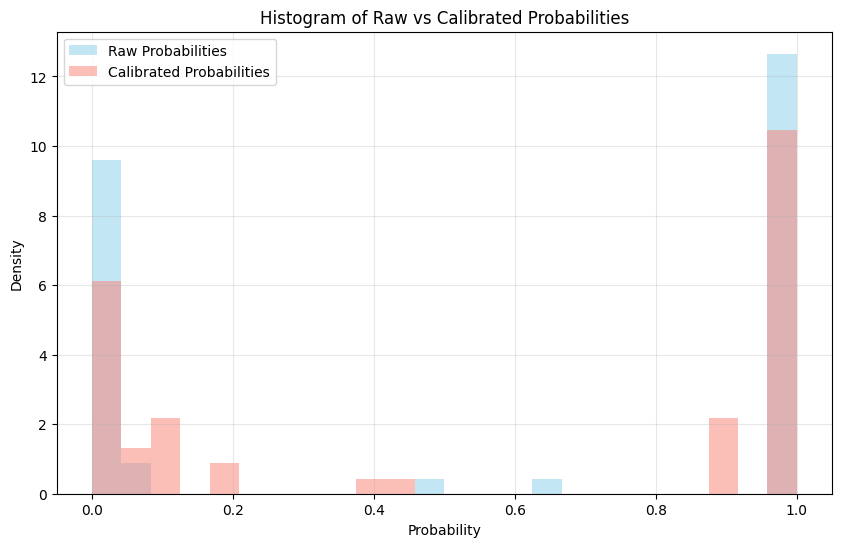

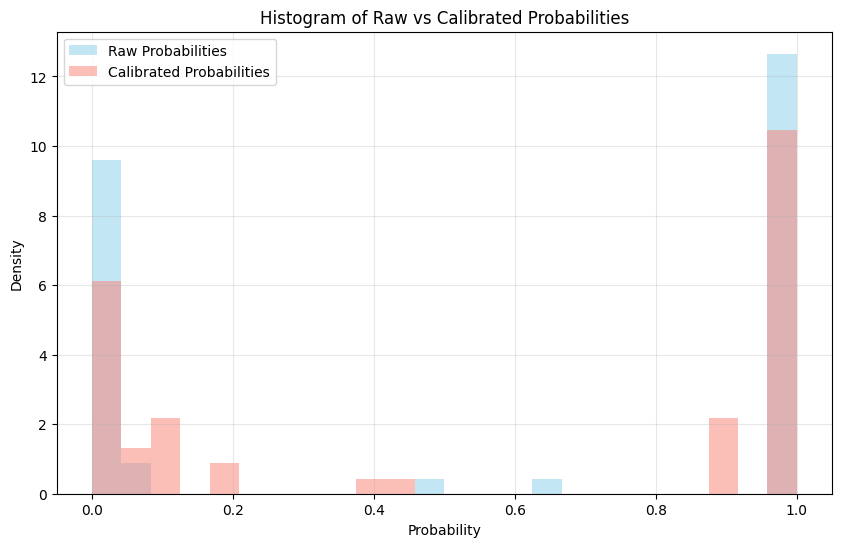

✅ Saved top candidate PNGs (GBM only).


In [39]:
# Cell 19 — Minimal candidate report PNG generation (GBM only)
import matplotlib.pyplot as plt

# Top 10 candidates by calibrated GBM probability
topk = out_df.sort_values('prob_calibrated', ascending=False).head(10)

for idx, row in topk.iterrows():
    i = int(row.name)  # row index in out_df
    fig, ax = plt.subplots(figsize=(6,4))
    
    # Bar plot of calibrated GBM probability
    ax.bar(['GBM'], [row['prob_calibrated']], color='skyblue')
    ax.set_ylim(0,1)
    ax.set_ylabel("Calibrated Probability")
    ax.set_title(f"Candidate {i}")
    
    # Add candidate info as text
    info_text = f"Index: {i}\nLabel: {row['label']}\nGBM Calibrated Prob: {row['prob_calibrated']:.3f}"
    ax.text(0, 0.4, info_text, fontsize=10)
    
    plt.tight_layout()
    fname = f"candidate_{i}.png"
    plt.savefig(fname, dpi=150)
    plt.close(fig)


    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    bins = np.linspace(0, 1, 25)  # 25 bins from 0 to 1

    plt.hist(y_test_prob, bins=bins, alpha=0.5, label='Raw Probabilities', color='skyblue', density=True)
    plt.hist(preds_test_cal, bins=bins, alpha=0.5, label='Calibrated Probabilities', color='salmon', density=True)
    
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title('Histogram of Raw vs Calibrated Probabilities')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


print("✅ Saved top candidate PNGs (GBM only).")


In [ ]:
# Cell 20 — Short notes and what to run next (instructions)
print("""
Notebook complete (baseline).
Next steps / optional (if time permits):
- If you have actual TESS/Kepler FITS lightcurves, adjust load_lc_by_targetid to point to them; then re-run dataset build to use real data.
- Add more handcrafted features (odd-even depth difference, centroid shift from TPFs if available).
- Increase CNN capacity and epochs, or use data augmentation & injection-recovery.
- Replace simple saliency with Integrated Gradients for better interpretability.
- Build a Streamlit vet UI (quick) that loads candidate_report_test.csv and shows candidate_{i}.png — good for human-in-the-loop.
- Save models (cnn_model.h5 and lgbm model) and pack notebook with a Dockerfile for reproducibility.
""")


# Testing case for app deployment

0% (33/19643) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).
5% (983/19261) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).


Skipping TIC 219006972 due to error: 'NoneType' object has no attribute 'remove_nans'
Skipping TIC 220517578 due to error: 'NoneType' object has no attribute 'remove_nans'


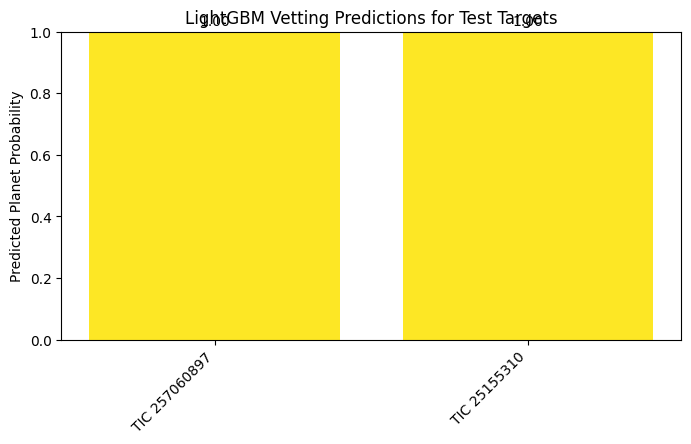

In [44]:
# Demo Cell — Load saved model and test on 4–5 real TIC targets

import matplotlib.pyplot as plt
import numpy as np
import joblib
import lightkurve as lk

# Load trained model
clf_loaded = joblib.load("vetting_lightgbm.pkl")

# Example TIC targets
test_targets = ["TIC 257060897", "TIC 219006972", "TIC 220517578", "TIC 25155310"]

# Feature extraction matching your trained model (10 features)
def extract_features(time, flux):
    from lightkurve.periodogram import BoxLeastSquares
    try:
        bls = BoxLeastSquares(time, flux)
        results = bls.autopower(0.05)
        idx = np.argmax(results.power)

        p = results.period[idx]
        depth = results.depth[idx]
        dur = results.duration[idx]
        power = results.power[idx]

        snr = depth / (np.std(flux) + 1e-9)
        mean_flux = np.mean(flux)
        std_flux = np.std(flux)
        rng = np.max(flux) - np.min(flux)
        skew_flux = np.mean((flux - mean_flux) ** 3) / ((std_flux + 1e-9) ** 3)
        kurt_flux = np.mean((flux - mean_flux) ** 4) / ((std_flux + 1e-9) ** 4)

        return [p, depth, dur, power, snr, mean_flux, std_flux, rng, skew_flux, kurt_flux]
    except Exception:
        return [0]*10  # return 10 zeros if extraction fails

# Prepare lists to store results
X_demo, names = [], []

for target in test_targets:
    try:
        search = lk.search_lightcurve(target, mission="TESS", author="SPOC", cadence="short")
        lc = search.download().remove_nans().normalize()
        t, f = lc.time.value, lc.flux.value
        feats = extract_features(t, f)
        X_demo.append(feats)
        names.append(target)
    except Exception as e:
        print(f"Skipping {target} due to error: {e}")

X_demo = np.array(X_demo)
pred_probs = clf_loaded.predict_proba(X_demo)[:, 1]

# Plot predictions
plt.figure(figsize=(8,4))
bars = plt.bar(names, pred_probs, color=plt.cm.viridis(pred_probs))
plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted Planet Probability")
plt.title("LightGBM Vetting Predictions for Test Targets")
plt.ylim(0,1)
for i, p in enumerate(pred_probs):
    plt.text(i, p+0.02, f"{p:.2f}", ha="center")
plt.show()


0% (33/19643) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).
0% (30/17483) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).
5% (983/19261) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).


TIC 220517578 not found in CSV, skipping.

Predicted probabilities for demo TICs:
TIC 257060897: Probability = 1.00, True Label = 1.0
TIC 97700520: Probability = 1.00, True Label = 0.0
TIC 25155310: Probability = 1.00, True Label = 1.0

ROC-AUC on demo TICs: 1.000


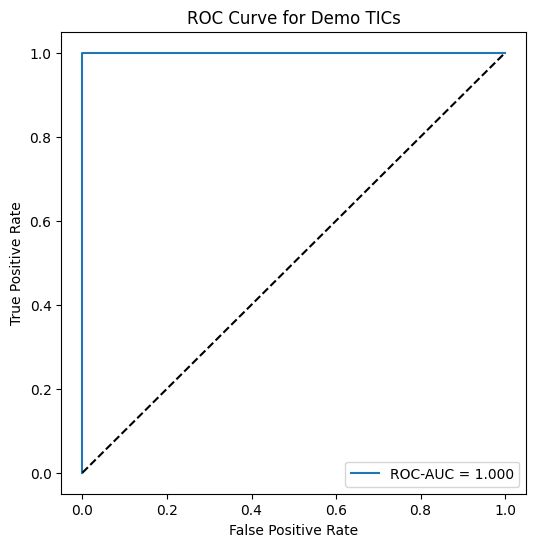

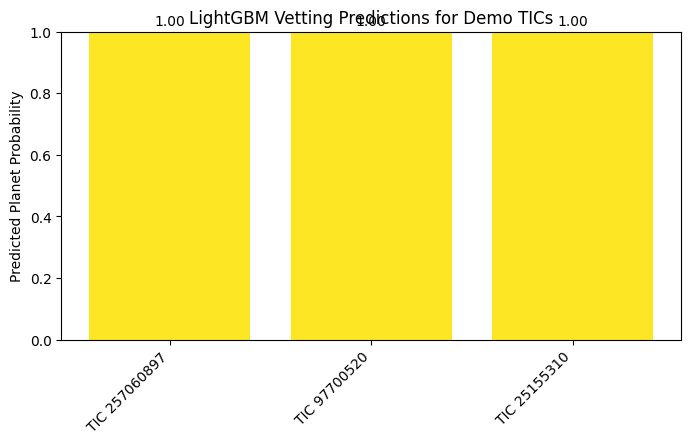

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
import lightkurve as lk
from sklearn.metrics import roc_auc_score, roc_curve

# Load trained model
clf_loaded = joblib.load("vetting_lightgbm.pkl")

# Load CSV, skip first 70 rows
df = pd.read_csv("/kaggle/input/kepler-and-tess-dataset/TOI_2025.02.03_06.18.31.csv", skiprows=69)

# Strip column names of whitespace
df.columns = df.columns.str.strip()

# Map tfopwg_disp to numeric labels
label_map = {"CP":1, "PC":1, "KP":1, "FP":0}
df['label'] = df['tfopwg_disp'].map(label_map)

# Drop rows where label is missing
df = df.dropna(subset=['label'])

# Feature extraction function
def extract_features(time, flux):
    from lightkurve.periodogram import BoxLeastSquares
    try:
        bls = BoxLeastSquares(time, flux)
        results = bls.autopower(0.05)
        idx = np.argmax(results.power)

        p = results.period[idx]
        depth = results.depth[idx]
        dur = results.duration[idx]
        power = results.power[idx]

        snr = depth / (np.std(flux) + 1e-9)
        mean_flux = np.mean(flux)
        std_flux = np.std(flux)
        rng = np.max(flux) - np.min(flux)
        skew_flux = np.mean((flux - mean_flux) ** 3) / ((std_flux + 1e-9) ** 3)
        kurt_flux = np.mean((flux - mean_flux) ** 4) / ((std_flux + 1e-9) ** 4)

        return [p, depth, dur, power, snr, mean_flux, std_flux, rng, skew_flux, kurt_flux]
    except Exception:
        return [0]*10

# User-provided TICs for demo
demo_tics = [257060897, 97700520, 220517578, 25155310]

X_demo, names, true_labels = [], [], []

for tic_id in demo_tics:
    # Get label from CSV
    label_row = df[df['tid'] == tic_id]
    if label_row.empty:
        print(f"TIC {tic_id} not found in CSV, skipping.")
        continue
    label = label_row['label'].values[0]

    # Download lightcurve and extract features
    try:
        search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author="SPOC", cadence="short")
        lc = search.download().remove_nans().normalize()
        t, f = lc.time.value, lc.flux.value
        feats = extract_features(t, f)
        X_demo.append(feats)
        names.append(f"TIC {tic_id}")
        true_labels.append(label)
    except Exception as e:
        print(f"Skipping TIC {tic_id} due to error: {e}")

# Convert to numpy arrays
X_demo = np.array(X_demo)
true_labels = np.array(true_labels)

# Predict probabilities
pred_probs = clf_loaded.predict_proba(X_demo)[:, 1]

# Print predictions
print("\nPredicted probabilities for demo TICs:")
for name, prob, label in zip(names, pred_probs, true_labels):
    print(f"{name}: Probability = {prob:.2f}, True Label = {label}")

# Compute ROC-AUC if both classes are present
if len(np.unique(true_labels)) == 2:
    roc_auc = roc_auc_score(true_labels, pred_probs)
    print(f"\nROC-AUC on demo TICs: {roc_auc:.3f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Demo TICs")
    plt.legend()
    plt.show()
else:
    print("\nROC-AUC cannot be computed: only one class present in the demo TICs.")

# Bar plot of predicted probabilities
plt.figure(figsize=(8,4))
bars = plt.bar(names, pred_probs, color=plt.cm.viridis(pred_probs))
plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted Planet Probability")
plt.title("LightGBM Vetting Predictions for Demo TICs")
plt.ylim(0,1)
for i, p in enumerate(pred_probs):
    plt.text(i, p+0.02, f"{p:.2f}", ha="center")
plt.show()
